In [2]:
import imageio
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, AveragePooling2D, Flatten, Dense, Dropout, AveragePooling2D, Flatten, Dropout, LSTM, Concatenate
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import tensorflow as tf

2024-10-20 01:25:00.283591: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-20 01:25:00.360637: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-20 01:25:00.382069: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-20 01:25:00.516004: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-20 01:25:01.604703: W tensorflow/compiler/tf2

In [18]:
def preprocess_imagery(path):
    '''
    Pre process satellite imagery. We check for nans in the composite images,
    and then we load them into the [0,1] range.
    Input: TIF files downloaded from GEE (224x224x7)
    '''
    # Reading image
    path = str(path).strip('b').strip("'")
    path="./GEE_Images/GEE_Images/"+path+".tif"
    image = (imageio.imread(path))
    """if np.sum(np.isnan(image)) > 0:
        # Taking the mean of the image, per channel
        mean = np.nanmean(image, axis=(0, 1))
        # Replacing NaN with per channel mean
        replacement = np.isnan(image) * mean
        image[np.isnan(image)] = replacement[np.isnan(image)]  
        nan_channels = np.all(np.isnan(image), axis=(0, 1))
        # Replacing NaN with 0 where all values in a channel are NaN
        image[:, :, nan_channels] = np.nan_to_num(image[:, :, nan_channels])
    # Scale the image to [0, 1] range
    image = image / 255"""
    return image

In [10]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

I0000 00:00:1729398434.851327    6786 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729398434.851441    6786 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729398434.851492    6786 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 4070, pci bus id: 0000:05:00.0, compute capability: 8.9



I0000 00:00:1729398435.123349    6786 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1729398435.123499    6786 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-20 01:27:15.123519: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2112] Could not identify NUMA node of platform GPU id 0, defaulting to 0.  Your kernel may not have been built with NUMA support.
I0000 00:00:1729398435.123595    6786 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:05:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-10-20 01:27:15.124018: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9558 MB memory:  -> device: 0, name: NVIDIA GeF

In [17]:
!pwd

/home/benjaxmen


In [20]:
image_files = [f for f in os.listdir("./GEE_Images/GEE_Images")]
image_info = []
#df = pd.read_csv('processed_data.csv')
"""
for image in image_files:
    name, _ = os.path.splitext(image)
    # Extraer estación y fecha de las imágenes
    station = '_'.join(name.split(' ')[0].split('_')[:-1])
    date = name.split(' ')[0].split('_')[-1]
    image_info.append([station, date,name])

# Añadimos una columna para asociar imágenes en df
df['image'] = None  # Inicialmente sin imágenes asociadas

# Ahora asociamos cada imagen a su registro en df
for info in image_info:
    df.loc[(df['station'] == info[0]) & (df['Date'] == info[1]), 'image'] = info[2]
"""
# Verificar que las imágenes se han asignado correctamente
df=pd.read_csv('dataframe_final.csv')

In [21]:
df_Scaled=df.copy()
# Crear un diccionario para almacenar los datos de cada locación
df_Scaled.fillna(value=0,inplace=True)
grouped_data = {location: location_df.sort_values(by='Date') for location, location_df in df_Scaled.groupby('station')}

In [22]:
df['image'].describe()

count                             51782
unique                            51782
top       El_bosque_1997-07-01 00_00_00
freq                                  1
Name: image, dtype: object

### Usando 7 días previos para predecir el día siguiente (Sin capping)

In [28]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [23]:
# Definir la métrica personalizada SMAPE
def smape(y_true, y_pred):
    epsilon = tf.keras.backend.epsilon()  # Pequeño valor para evitar divisiones por cero
    denominator = (tf.abs(y_true) + tf.abs(y_pred)) / 2.0 + epsilon
    diff = tf.abs(y_true - y_pred) / denominator
    return 100.0 * tf.reduce_mean(diff)  # Se devuelve el error en porcentaje


In [29]:


# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        880 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 26, 26,    │          0 │ conv2d_2[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 12, 12,    │          0 │ conv2d_3[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    589,952 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 7, 50)     │     13,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50)        │     20,200 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 178)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     22,912 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [24]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)


In [37]:
X_train[0].shape

(7, 17)

In [10]:
checkpoint_path = "training/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [39]:
history=model.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)

Epoch 1/50


C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_12']. Received: the structure of inputs=('*', '*')
  warnings.warn(
C:\Users\benja\AppData\Local\Temp\ipykernel_11080\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - loss: 0.0863 - mean_absolute_percentage_error: 136873.1719 - mean_squared_error: 0.5962 - smape: 52.7968
Epoch 1: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 969s 429ms/step - loss: 0.0862 - mean_absolute_percentage_error: 136849.4219 - mean_squared_error: 0.5960 - smape: 52.7951 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 92910.3750 - val_mean_squared_error: 9.1084e-04 - val_smape: 49.0097
Epoch 2/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:35 69ms/step - loss: 0.0152 - mean_absolute_percentage_error: 25.2768 - mean_squared_error: 3.5523e-04 - smape: 39.0289
Epoch 2: saving model to training/ckpt.weights.h5


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 96us/step - loss: 0.0152 - mean_absolute_percentage_error: 25.2768 - mean_squared_error: 3.5523e-04 - smape: 19.5231 - val_loss: 0.0190 - val_mean_absolute_percentage_error: 43.6166 - val_mean_squared_error: 7.1978e-04 - val_smape: 21.2371
Epoch 3/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - loss: 0.0187 - mean_absolute_percentage_error: 60771.3320 - mean_squared_error: 8.4582e-04 - smape: 48.6338
Epoch 3: saving model to training/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 915s 406ms/step - loss: 0.0187 - mean_absolute_percentage_error: 60775.0273 - mean_squared_error: 8.4580e-04 - smape: 48.6339 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 92221.3672 - val_mean_squared_error: 8.3083e-04 - val_smape: 48.9478
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 1:59 53ms/step - loss: 0.0135 - mean_absolute_percentage_error: 21.4849 - mean_squared_error: 2.9093e-04 - smape: 43.0578
Epoch 4: saving model to training/ckpt.weights.h5
2253/2253 ━━━

In [40]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()


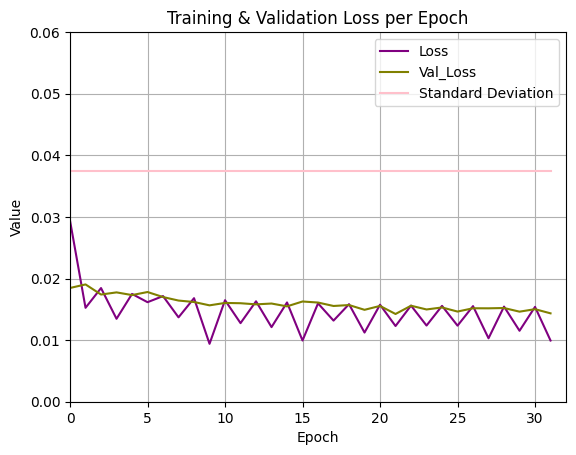

In [41]:
s=[df_Scaled.std()]*len(history.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history.history['loss'],  color='purple',label='Loss')
plt.plot(history.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model.png',format='png')
# Muestra el gráfico
plt.show()

In [42]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict = model.predict(test_dataset,steps=len(y_test))

C:\Users\benja\AppData\Local\Temp\ipykernel_11080\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


20706/20706 ━━━━━━━━━━━━━━━━━━━━ 205s 10ms/step


In [45]:
def smape_2(y_true, y_pred):
    """
    Calcula el Symmetric Mean Absolute Percentage Error.
    """
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-6))

In [52]:
# Calcular MAE
mae0 = mean_absolute_error(y_test, predict)
mse0= mean_squared_error(y_test, predict)
# Calcular R-squared
r20= r2_score(y_test, predict)


smape0 = smape_2(y_test, predict)

# Imprimir las métricas
print(f"MAE: {mae0}")
print(f"MSE: {mse0}")
print(f"R-squared: {r20}")
print(f"SMAPE: {smape0}%")

MAE: 0.024951122207249193
MSE: 0.00127273699185358
R-squared: 0.15893306975515364
SMAPE: 36.60100083635075%


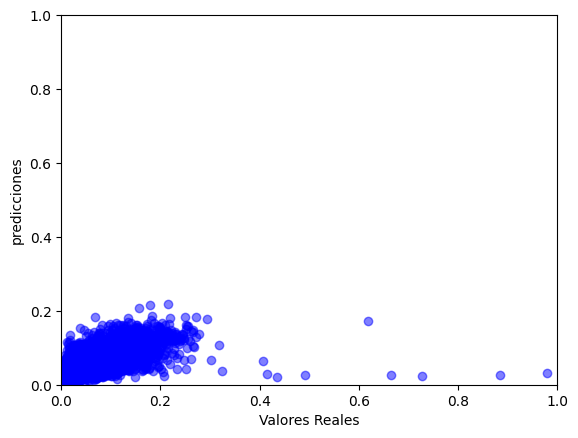

In [44]:
plt.scatter(y_test, predict, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

In [45]:
df['mp10'].describe()

count    151917.000000
mean         55.948889
std          34.322277
min           0.000000
25%          34.208300
50%          49.000000
75%          69.833300
max         917.940000
Name: mp10, dtype: float64

C:\Users\benja\AppData\Local\Temp\ipykernel_11080\4037668646.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict[a]))


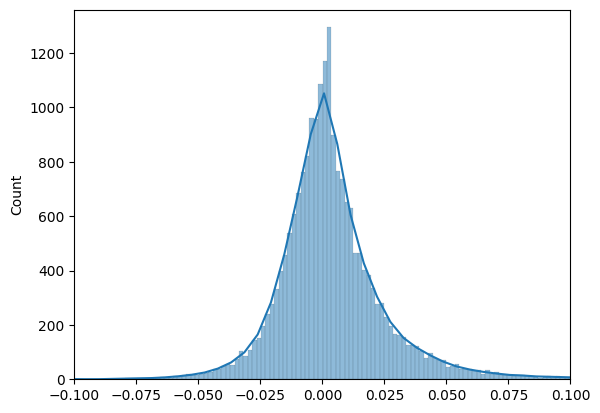

In [46]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 7 días para predecir promedio semanal siguiente (Sin capping)

In [47]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = np.mean(target[i:i+7])
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [59]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model1 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model1.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model1.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 222, 222,  │        880 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_8 │ (None, 111, 111,  │          0 │ conv2d_8[0][0]    │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_9 │ (None, 54, 54,    │          0 │ conv2d_9[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 26, 26,    │          0 │ conv2d_10[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 12, 12,    │          0 │ conv2d_11[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │    589,952 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 7, 50)     │     13,600 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 50)        │     20,200 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 178)       │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     22,912 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        129 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [50]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)
checkpoint_path = "training_1/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [60]:
history1=model1.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


Epoch 1/50


C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_38', 'keras_tensor_50']. Received: the structure of inputs=('*', '*')
  warnings.warn(
C:\Users\benja\AppData\Local\Temp\ipykernel_11080\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 553ms/step - loss: 0.0712 - mean_absolute_percentage_error: 17598.3320 - mean_squared_error: 0.4275 - smape: 46.2698
Epoch 1: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1435s 635ms/step - loss: 0.0712 - mean_absolute_percentage_error: 17599.0254 - mean_squared_error: 0.4273 - smape: 46.2686 - val_loss: 0.0182 - val_mean_absolute_percentage_error: 25639.5820 - val_mean_squared_error: 7.0605e-04 - val_smape: 43.0074
Epoch 2/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:33 68ms/step - loss: 0.0130 - mean_absolute_percentage_error: 19.6545 - mean_squared_error: 2.3933e-04 - smape: 34.1130
Epoch 2: saving model to training_1/ckpt.weights.h5


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 94us/step - loss: 0.0130 - mean_absolute_percentage_error: 19.6545 - mean_squared_error: 2.3933e-04 - smape: 17.0641 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 19.8043 - val_mean_squared_error: 4.5007e-04 - val_smape: 17.5535
Epoch 3/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 771ms/step - loss: 0.0185 - mean_absolute_percentage_error: 18074.3438 - mean_squared_error: 7.8881e-04 - smape: 43.5300
Epoch 3: saving model to training_1/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1993s 885ms/step - loss: 0.0185 - mean_absolute_percentage_error: 18074.7988 - mean_squared_error: 7.8881e-04 - smape: 43.5301 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 25779.6250 - val_mean_squared_error: 6.5755e-04 - val_smape: 44.2419
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 1:50 49ms/step - loss: 0.0096 - mean_absolute_percentage_error: 13.9618 - mean_squared_error: 1.3312e-04 - smape: 32.2919
Epoch 4: saving model to training_1/ckpt.weights.h5
2253/225

In [61]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()

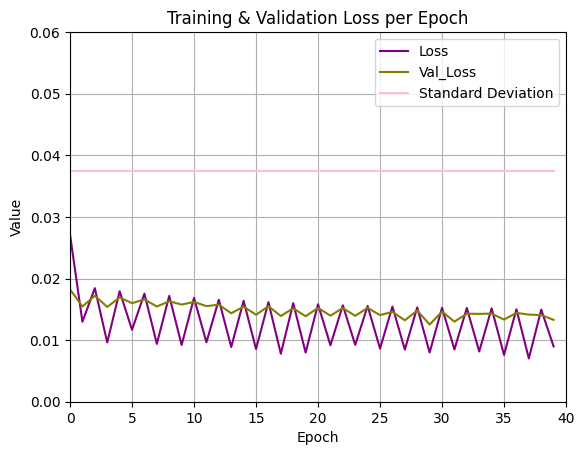

In [62]:
s=[df_Scaled.std()]*len(history1.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history1.history['loss'],  color='purple',label='Loss')
plt.plot(history1.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history1.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model1.png',format='png')
# Muestra el gráfico
plt.show()

In [63]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict1 = model1.predict(test_dataset,steps=len(y_test))

C:\Users\benja\AppData\Local\Temp\ipykernel_11080\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


20706/20706 ━━━━━━━━━━━━━━━━━━━━ 301s 15ms/step


In [64]:
# Calcular MAE
mae1 = mean_absolute_error(y_test, predict1)
mse1= mean_squared_error(y_test, predict1)
# Calcular R-squared
r21 = r2_score(y_test, predict1)
smape1 = smape_2(y_test, predict1)

# Imprimir las métricas
print(f"MAE: {mae1}")
print(f"MSE: {mse1}")
print(f"R-squared: {r21}")
print(f"SMAPE: {smape1}%")

MAE: 0.015039202210330043
MSE: 0.0006509588000405462
R-squared: 0.569824776705353
SMAPE: 20.962979259932805%


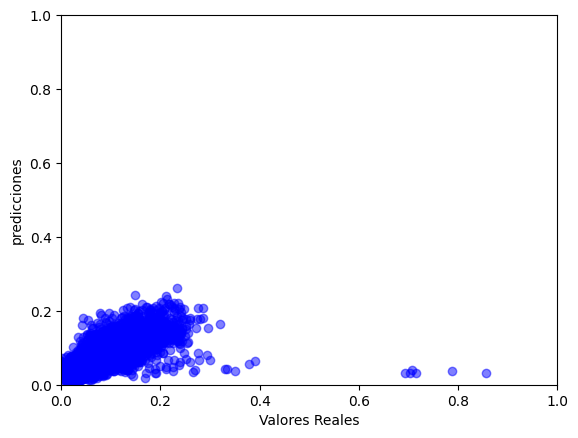

In [65]:
plt.scatter(y_test, predict1, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

C:\Users\benja\AppData\Local\Temp\ipykernel_11080\101343474.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict1[a]))


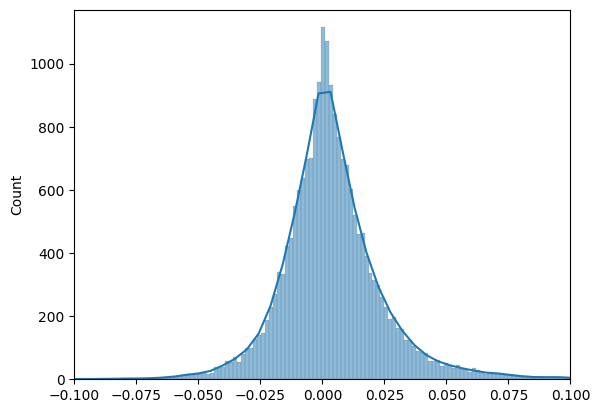

In [66]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict1[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 10 días previos para predecir el día siguiente (Sin capping)

In [11]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 10  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (123013, 10, 17), Forma de y: (123013, 1), Total de imágenes: (123013,)
Train set: X=(86109, 10, 17), y=(86109, 1), images=(86109,)
Test set: X=(24725, 10, 17), y=(24725, 1), images=(24725,)
Validation set: X=(12179, 10, 17), y=(12179, 1), images=(12179,)


In [12]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(10, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model2 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model2.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model2.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        880 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 26, 26,    │          0 │ conv2d_2[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 12, 12,    │          0 │ conv2d_3[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    589,952 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 10, 50)    │     13,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50)        │     20,200 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 178)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     22,912 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(10, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [14]:
checkpoint_path = "training_2/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [15]:
history2=model2.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


Epoch 1/50


C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_12']. Received: the structure of inputs=('*', '*')
  warnings.warn(
C:\Users\benja\AppData\Local\Temp\ipykernel_5520\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 582ms/step - loss: 0.0714 - mean_absolute_percentage_error: 1942210.1250 - mean_squared_error: 0.4122 - smape: 51.8500
Epoch 1: saving model to training_2/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1773s 658ms/step - loss: 0.0714 - mean_absolute_percentage_error: 1941605.8750 - mean_squared_error: 0.4120 - smape: 51.8489 - val_loss: 0.0193 - val_mean_absolute_percentage_error: 52322.6797 - val_mean_squared_error: 8.8122e-04 - val_smape: 47.6003
Epoch 2/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 5:25 121ms/step - loss: 0.0222 - mean_absolute_percentage_error: 35.9944 - mean_squared_error: 0.0010 - smape: 55.4007

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: saving model to training_2/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 169us/step - loss: 0.0222 - mean_absolute_percentage_error: 35.9944 - mean_squared_error: 0.0010 - smape: 27.7106 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 54.9887 - val_mean_squared_error: 0.0014 - val_smape: 26.2827
Epoch 3/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 575ms/step - loss: 0.0189 - mean_absolute_percentage_error: 68467.0781 - mean_squared_error: 8.5965e-04 - smape: 48.7270
Epoch 3: saving model to training_2/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1744s 648ms/step - loss: 0.0189 - mean_absolute_percentage_error: 68466.0391 - mean_squared_error: 8.5963e-04 - smape: 48.7272 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 49170.2461 - val_mean_squared_error: 6.9715e-04 - val_smape: 49.8924
Epoch 4/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:55 110ms/step - loss: 0.0186 - mean_absolute_percentage_error: 36.2597 - mean_squared_error: 6.0354e-04 - smape: 58.3789
Epoch 4: savi

In [17]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()

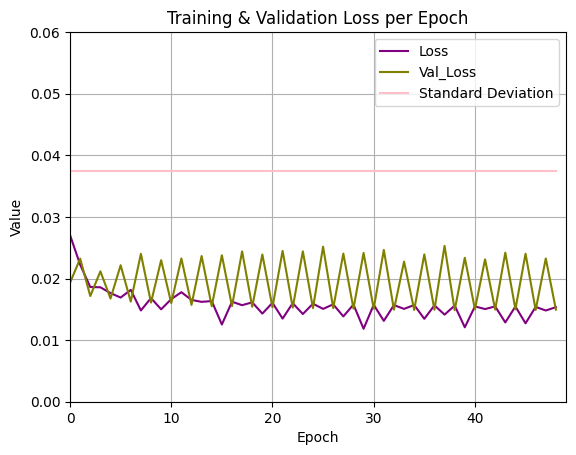

In [18]:
import matplotlib.pyplot as plt
s=[df_Scaled.std()]*len(history2.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history2.history['loss'],  color='purple',label='Loss')
plt.plot(history2.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history2.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model2.png',format='png')
# Muestra el gráfico
plt.show()

In [19]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict2 = model2.predict(test_dataset,steps=len(y_test))

C:\Users\benja\AppData\Local\Temp\ipykernel_5520\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


24725/24725 ━━━━━━━━━━━━━━━━━━━━ 281s 11ms/step


In [22]:

mae2 = mean_absolute_error(y_test, predict2)
mse2= mean_squared_error(y_test, predict2)
r22 = r2_score(y_test, predict2)
smape2 = smape_2(y_test, predict2)

# Imprimir las métricas
print(f"MAE: {mae2}")
print(f"MSE: {mse2}")
print(f"R-squared: {r22}")
print(f"SMAPE: {smape2}%")

MAE: 0.014961800408023352
MSE: 0.0006376001851182003
R-squared: 0.49623836986603576
SMAPE: 26.88063364076384%


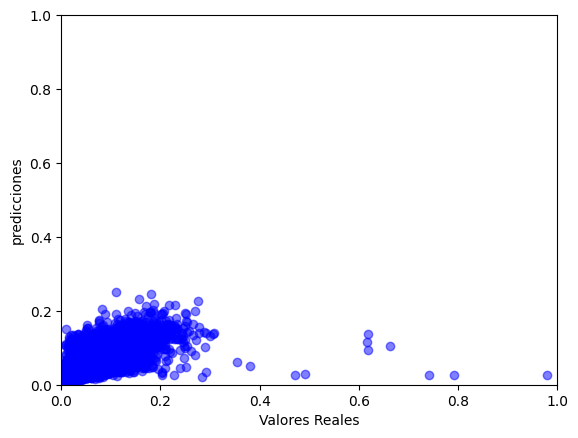

In [23]:
plt.scatter(y_test, predict2, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

C:\Users\benja\AppData\Local\Temp\ipykernel_5520\1642356656.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict2[a]))


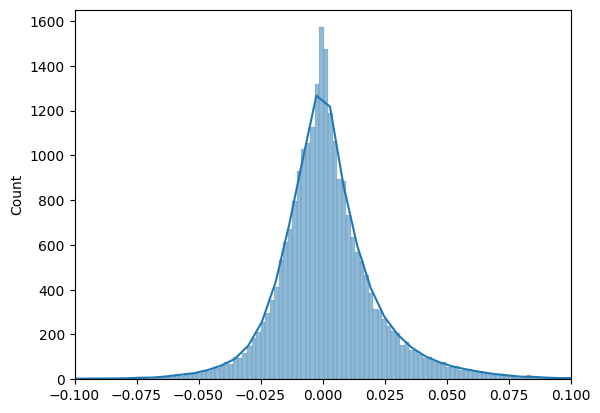

In [24]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict2[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 10 días previos para predecir el promedio de la semana siguiente (Sin capping)

In [8]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 10  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = np.mean(target[i:i+7])
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (123013, 10, 17), Forma de y: (123013, 1), Total de imágenes: (123013,)
Train set: X=(86109, 10, 17), y=(86109, 1), images=(86109,)
Test set: X=(24725, 10, 17), y=(24725, 1), images=(24725,)
Validation set: X=(12179, 10, 17), y=(12179, 1), images=(12179,)


In [9]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(10, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model3 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model3.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model3.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 222, 222,  │        880 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d   │ (None, 111, 111,  │          0 │ conv2d[0][0]      │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_1 │ (None, 54, 54,    │          0 │ conv2d_1[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_2 │ (None, 26, 26,    │          0 │ conv2d_2[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_3 │ (None, 12, 12,    │          0 │ conv2d_3[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 10, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    589,952 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 10, 50)    │     13,600 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 50)        │     20,200 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 178)       │          0 │ dropout[0][0],    │
│ (Concatenate)       │                   │            │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     22,912 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(10, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [11]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)
checkpoint_path = "training_3/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [12]:
history3=model3.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


Epoch 1/50


C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_12']. Received: the structure of inputs=('*', '*')
  warnings.warn(
C:\Users\benja\AppData\Local\Temp\ipykernel_5316\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step - loss: 0.1693 - mean_absolute_percentage_error: 18596.8223 - mean_squared_error: 3.8687 - smape: 46.2275
Epoch 1: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1173s 435ms/step - loss: 0.1692 - mean_absolute_percentage_error: 18596.3809 - mean_squared_error: 3.8675 - smape: 46.2265 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 14203.5977 - val_mean_squared_error: 7.1363e-04 - val_smape: 44.9297
Epoch 2/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 5:30 123ms/step - loss: 0.0195 - mean_absolute_percentage_error: 26.0691 - mean_squared_error: 7.0406e-04 - smape: 48.3202
Epoch 2: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 60us/step - loss: 0.0195 - mean_absolute_percentage_error: 26.0691 - mean_squared_error: 7.0406e-04 - smape: 24.1691 - val_loss: 0.0195 - val_mean_absolute_percentage_error: 42.8201 - val_mean_squared_error: 0.0013 - val_smape: 24.5284
Epoch 3/50


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - loss: 0.0183 - mean_absolute_percentage_error: 17843.1621 - mean_squared_error: 7.4595e-04 - smape: 43.4468
Epoch 3: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1106s 411ms/step - loss: 0.0183 - mean_absolute_percentage_error: 17842.9043 - mean_squared_error: 7.4595e-04 - smape: 43.4469 - val_loss: 0.0168 - val_mean_absolute_percentage_error: 13028.6035 - val_mean_squared_error: 6.8902e-04 - val_smape: 46.1010
Epoch 4/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 5:00 112ms/step - loss: 0.0175 - mean_absolute_percentage_error: 22.1194 - mean_squared_error: 6.4495e-04 - smape: 48.5804
Epoch 4: saving model to training_3/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 54us/step - loss: 0.0175 - mean_absolute_percentage_error: 22.1194 - mean_squared_error: 6.4495e-04 - smape: 24.2992 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 33.4007 - val_mean_squared_error: 8.9883e-04 - val_smape: 24.6803
Epoch 5/50
2690/26

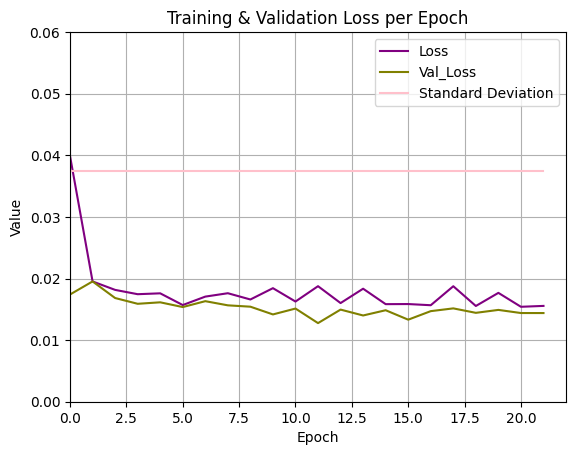

In [13]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()
s=[df_Scaled.std()]*len(history3.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history3.history['loss'],  color='purple',label='Loss')
plt.plot(history3.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history3.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model3.png',format='png')
# Muestra el gráfico
plt.show()

In [14]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict3 = model3.predict(test_dataset,steps=len(y_test))

C:\Users\benja\AppData\Local\Temp\ipykernel_5316\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


24725/24725 ━━━━━━━━━━━━━━━━━━━━ 406s 16ms/step


In [17]:
# Calcular MAE
mae3 = mean_absolute_error(y_test, predict3)
mse3= mean_squared_error(y_test, predict3)
# Calcular R-squared
r23 = r2_score(y_test, predict3)

smape3 = smape_2(y_test, predict3)

# Imprimir las métricas
print(f"MAE: {mae3}")
print(f"MSE: {mse3}")
print(f"R-squared: {r23}")
print(f"SMAPE: {smape3}%")

MAE: 0.015111808376505815
MSE: 0.0006279599663901092
R-squared: 0.5596637058149658
SMAPE: 21.026700528941657%


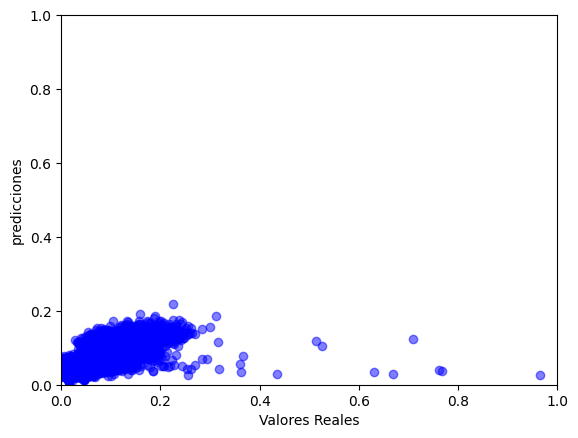

In [18]:
plt.scatter(y_test, predict3, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

C:\Users\benja\AppData\Local\Temp\ipykernel_5316\2902670054.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict3[a]))


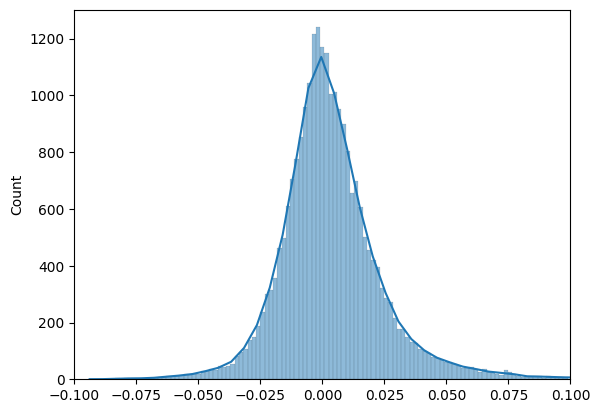

In [19]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict3[a]))
    import seaborn as sns
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 7 días para predecir día siguiente (Capping)

In [35]:
# Calcular la media y la desviación estándar
mean = df['mp10'].mean()
std = df['mp10'].std()

# Definir límites usando múltiplos de la desviación estándar (ej. 3 desviaciones estándar)
lower_cap = mean - 3 * std  # Límite inferior: media - 3 veces la desviación estándar
upper_cap = mean + 3 * std  # Límite superior: media + 3 veces la desviación estándar

# Aplicar el capping
df['mp10'] = df['mp10'].clip(lower=lower_cap, upper=upper_cap)

In [21]:
df['mp10'].describe()

count    151917.000000
mean         55.373795
std          31.277526
min           0.000000
25%          34.208300
50%          49.000000
75%          69.833300
max         158.915720
Name: mp10, dtype: float64

In [22]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.preprocessing import MinMaxScaler


# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [23]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model4 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model4.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model4.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │        880 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_4 │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_5 │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_6 │ (None, 26, 26,    │          0 │ conv2d_6[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_7 │ (None, 12, 12,    │          0 │ conv2d_7[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │    589,952 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 7, 50)     │     13,600 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 50)        │     20,200 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 178)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     22,912 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [25]:
checkpoint_path = "training_4/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [26]:
history4=model4.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)




Epoch 1/50


C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_19', 'keras_tensor_31']. Received: the structure of inputs=('*', '*')
  warnings.warn(
C:\Users\benja\AppData\Local\Temp\ipykernel_5316\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 560ms/step - loss: 0.1622 - mean_absolute_percentage_error: 186615.2188 - mean_squared_error: 3.0469 - smape: 51.5923
Epoch 1: saving model to training_4/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1420s 629ms/step - loss: 0.1621 - mean_absolute_percentage_error: 186573.8594 - mean_squared_error: 3.0458 - smape: 51.5909 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 96658.4688 - val_mean_squared_error: 9.2296e-04 - val_smape: 48.1205
Epoch 2/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:33 68ms/step - loss: 0.0125 - mean_absolute_percentage_error: 18.9823 - mean_squared_error: 2.7448e-04 - smape: 38.2604
Epoch 2: saving model to training_4/ckpt.weights.h5


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 95us/step - loss: 0.0125 - mean_absolute_percentage_error: 18.9823 - mean_squared_error: 2.7448e-04 - smape: 19.1387 - val_loss: 0.0186 - val_mean_absolute_percentage_error: 41.8229 - val_mean_squared_error: 6.1309e-04 - val_smape: 20.1185
Epoch 3/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 527ms/step - loss: 0.0186 - mean_absolute_percentage_error: 62076.2969 - mean_squared_error: 8.3568e-04 - smape: 48.5069
Epoch 3: saving model to training_4/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1333s 592ms/step - loss: 0.0186 - mean_absolute_percentage_error: 62079.7148 - mean_squared_error: 8.3567e-04 - smape: 48.5070 - val_loss: 0.0177 - val_mean_absolute_percentage_error: 93012.8906 - val_mean_squared_error: 8.5423e-04 - val_smape: 47.3088
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 1:46 47ms/step - loss: 0.0128 - mean_absolute_percentage_error: 19.7933 - mean_squared_error: 2.7777e-04 - smape: 38.6772
Epoch 4: saving model to training_4/ckpt.weights.h5
2253/225

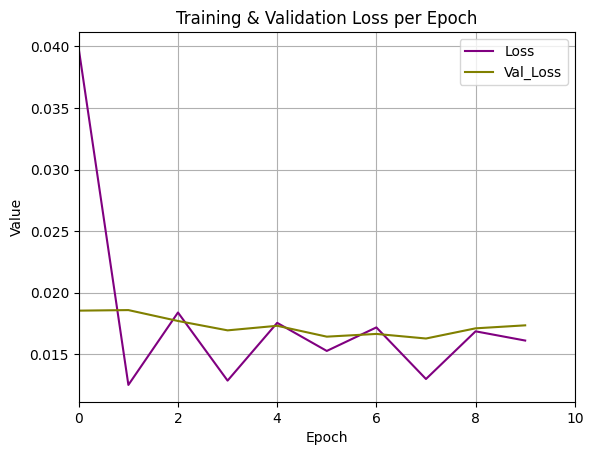

In [27]:
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history4.history['loss'],  color='purple',label='Loss')
plt.plot(history4.history['val_loss'],color='olive',label='Val_Loss')

# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')

plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history4.history['loss']))

plt.legend()

plt.grid(True)
# Muestra el gráfico
plt.show()

In [28]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict4 = model4.predict(test_dataset,steps=len(y_test))

C:\Users\benja\AppData\Local\Temp\ipykernel_5316\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


   10/20706 ━━━━━━━━━━━━━━━━━━━━ 4:03 12ms/step   

20706/20706 ━━━━━━━━━━━━━━━━━━━━ 256s 12ms/step


In [29]:
# Calcular MAE
mae4 = mean_absolute_error(y_test, predict4)
mse4= mean_squared_error(y_test, predict4)
# Calcular R-squared
r24 = r2_score(y_test, predict4)
smape4 = smape_2(y_test, predict4)

# Imprimir las métricas
print(f"MAE: {mae4}")
print(f"MSE: {mse4}")
print(f"R-squared: {r24}")
print(f"SMAPE: {smape4}%")

MAE: 0.018601448325700865
MSE: 0.0009028183161912945
R-squared: 0.2993115697945907
SMAPE: 33.3972011408633%


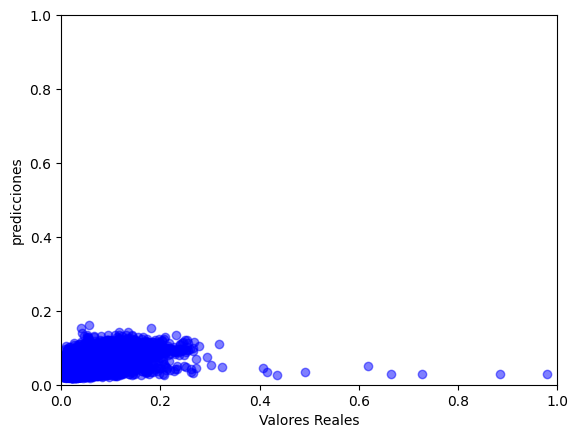

In [30]:
plt.scatter(y_test, predict4, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

C:\Users\benja\AppData\Local\Temp\ipykernel_5316\950517328.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict4[a]))


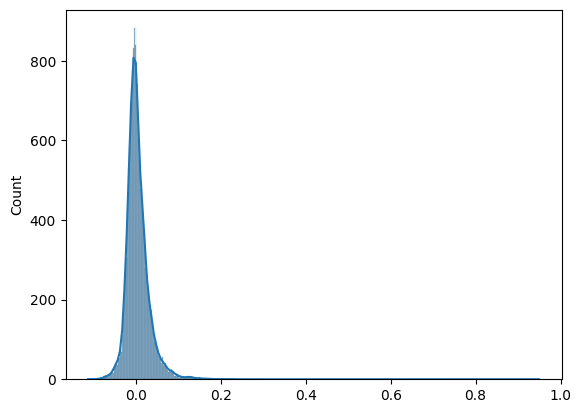

In [31]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict4[a]))
    import seaborn as sns
sns.histplot(residuos,kde=True,bins=600)
plt.show()

### Usando 7 días para predecir día siguiente (Capping)

In [32]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 7  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = np.mean(target[i:i+7])
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (103015, 7, 17), Forma de y: (103015, 1), Total de imágenes: (103015,)
Train set: X=(72110, 7, 17), y=(72110, 1), images=(72110,)
Test set: X=(20706, 7, 17), y=(20706, 1), images=(20706,)
Validation set: X=(10199, 7, 17), y=(10199, 1), images=(10199,)


In [37]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(7, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model5 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model5.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model5.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 222, 222,  │        880 │ input_layer_6[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 111, 111,  │          0 │ conv2d_12[0][0]   │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 54, 54,    │          0 │ conv2d_13[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 26, 26,    │          0 │ conv2d_14[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 12, 12,    │          0 │ conv2d_15[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, 7, 17)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 128)       │    589,952 │ flatten_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_6 (LSTM)       │ (None, 7, 50)     │     13,600 │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, 128)       │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_7 (LSTM)       │ (None, 50)        │     20,200 │ lstm_6[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 178)       │          0 │ dropout_6[0][0],  │
│ (Concatenate)       │                   │            │ lstm_7[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 128)       │     22,912 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128)       │          0 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │        129 │ dropout_7[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(7, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [35]:
# Configurar Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)
checkpoint_path = "training_5/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [38]:
model5.load_weights(checkpoint_path)

C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [36]:
history5=model5.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()

Epoch 1/50


C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_38', 'keras_tensor_50']. Received: the structure of inputs=('*', '*')
  warnings.warn(
C:\Users\benja\AppData\Local\Temp\ipykernel_5316\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 420ms/step - loss: 0.1018 - mean_absolute_percentage_error: 17663.5918 - mean_squared_error: 1.2898 - smape: 46.5222
Epoch 1: saving model to training_5/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1063s 470ms/step - loss: 0.1017 - mean_absolute_percentage_error: 17664.0938 - mean_squared_error: 1.2893 - smape: 46.5210 - val_loss: 0.0178 - val_mean_absolute_percentage_error: 25058.7695 - val_mean_squared_error: 6.8658e-04 - val_smape: 44.7796
Epoch 2/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:12 59ms/step - loss: 0.0138 - mean_absolute_percentage_error: 21.0573 - mean_squared_error: 2.9551e-04 - smape: 37.0082

C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.12_3.12.2032.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 2: saving model to training_5/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1s 249us/step - loss: 0.0138 - mean_absolute_percentage_error: 21.0573 - mean_squared_error: 2.9551e-04 - smape: 18.5123 - val_loss: 0.0164 - val_mean_absolute_percentage_error: 20.3681 - val_mean_squared_error: 4.8257e-04 - val_smape: 18.5905
Epoch 3/50
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step - loss: 0.0186 - mean_absolute_percentage_error: 17733.2559 - mean_squared_error: 7.8854e-04 - smape: 43.7473
Epoch 3: saving model to training_5/ckpt.weights.h5
2253/2253 ━━━━━━━━━━━━━━━━━━━━ 1029s 457ms/step - loss: 0.0186 - mean_absolute_percentage_error: 17733.8203 - mean_squared_error: 7.8854e-04 - smape: 43.7473 - val_loss: 0.0174 - val_mean_absolute_percentage_error: 25698.3672 - val_mean_squared_error: 6.9171e-04 - val_smape: 43.7214
Epoch 4/50
   1/2253 ━━━━━━━━━━━━━━━━━━━━ 2:06 56ms/step - loss: 0.0110 - mean_absolute_percentage_error: 15.6576 - mean_squared_error: 1.9744e-04 - smape: 30.3991
Epoch 

KeyboardInterrupt: 

In [40]:
import matplotlib.pyplot as plt
s=[df_Scaled.std()]*30
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history5.history['loss'],  color='purple',label='Loss')
plt.plot(history5.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history5.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model5.png',format='png')
# Muestra el gráfico
plt.show()

NameError: name 'history5' is not defined

In [42]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict5 = model5.predict(test_dataset,steps=len(y_test))

C:\Users\benja\AppData\Local\Temp\ipykernel_5316\2794921389.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))
C:\Users\benja\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_57', 'keras_tensor_69']. Received: the structure of inputs=('*', '*')
  warnings.warn(


20706/20706 ━━━━━━━━━━━━━━━━━━━━ 340s 16ms/step


In [43]:
# Calcular MAE
mae5 = mean_absolute_error(y_test, predict5)
mse5= mean_squared_error(y_test, predict5)
# Calcular R-squared
r25 = r2_score(y_test, predict5)
smape5 = smape_2(y_test, predict5)

# Imprimir las métricas
print(f"MAE: {mae5}")
print(f"MSE: {mse5}")
print(f"R-squared: {r25}")
print(f"SMAPE: {smape5}%")

MAE: 0.014784230964475288
MSE: 0.000636672932877727
R-squared: 0.5792653528160695
SMAPE: 19.800282392672976%


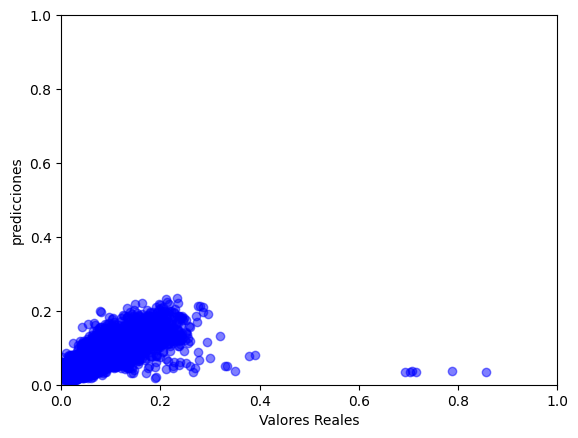

In [44]:
plt.scatter(y_test, predict5, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

C:\Users\benja\AppData\Local\Temp\ipykernel_5316\918445844.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict5[a]))


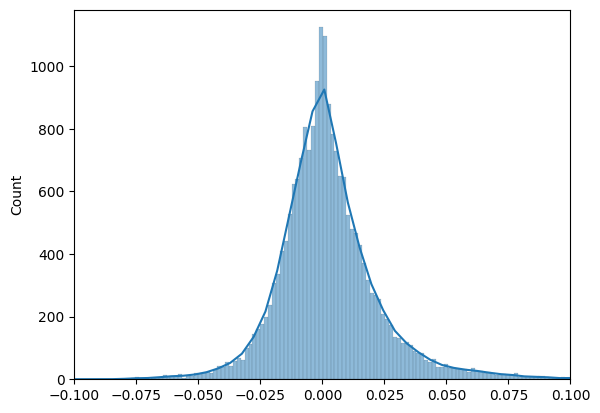

In [45]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict5[a]))
    import seaborn as sns
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 10 días previos para predecir el día siguiente (Capping)

In [36]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 10  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = target[i]
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (123013, 10, 17), Forma de y: (123013, 1), Total de imágenes: (123013,)
Train set: X=(86109, 10, 17), y=(86109, 1), images=(86109,)
Test set: X=(24725, 10, 17), y=(24725, 1), images=(24725,)
Validation set: X=(12179, 10, 17), y=(12179, 1), images=(12179,)


In [37]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(10, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model6 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model6.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model6.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 222, 222,  │        880 │ input_layer_2[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_4 │ (None, 111, 111,  │          0 │ conv2d_4[0][0]    │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_5 │ (None, 54, 54,    │          0 │ conv2d_5[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_6 │ (None, 26, 26,    │          0 │ conv2d_6[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_7 │ (None, 12, 12,    │          0 │ conv2d_7[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 10, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │    589,952 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 10, 50)    │     13,600 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 50)        │     20,200 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 178)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     22,912 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │        129 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [38]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(10, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [39]:
checkpoint_path = "training_6/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [40]:
history6=model6.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


Epoch 1/50


/home/benjaxmen/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_19', 'keras_tensor_31']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/tmp/ipykernel_6786/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))
2024-10-20 01:56:41.555151: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1729400201.806081 2027554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400201.872194 2027554 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400201.928717 2027554 gpu_timer.cc:114] Skip

2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - loss: 0.0920 - mean_absolute_percentage_error: 633352.9375 - mean_squared_error: 0.6865 - smape: 52.0476

W0000 00:00:1729400667.431914 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400667.505666 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400667.514086 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400667.532312 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400667.541439 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400667.546181 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400667.593443 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400667.618093 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400667.642803 2027553 gp


Epoch 1: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 528s 195ms/step - loss: 0.0920 - mean_absolute_percentage_error: 633170.2500 - mean_squared_error: 0.6862 - smape: 52.0465 - val_loss: 0.0185 - val_mean_absolute_percentage_error: 56834.3672 - val_mean_squared_error: 7.8762e-04 - val_smape: 47.2891
Epoch 2/50


W0000 00:00:1729400726.929831 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400726.933742 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400726.937258 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400726.943806 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400726.947631 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400726.952394 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400726.963867 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400726.977583 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400726.985519 2027556 gp

   1/2690 ━━━━━━━━━━━━━━━━━━━━ 40:25 902ms/step - loss: 0.0196 - mean_absolute_percentage_error: 36.9607 - mean_squared_error: 8.8638e-04 - smape: 55.1509

W0000 00:00:1729400727.740325 2027558 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400727.744211 2027558 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400727.747813 2027558 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400727.753205 2027558 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
2024-10-20 02:05:27.786195: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-20 02:05:27.786600: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/functional_1_1/dropout_3_1/Cast/_13]]
2024-10-20 02:05:27.786658: I tensorflow/core/framework/local_rendezvous.cc:423] Local


Epoch 2: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 129us/step - loss: 0.0196 - mean_absolute_percentage_error: 36.9607 - mean_squared_error: 8.8638e-04 - smape: 27.5857 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 67.4735 - val_mean_squared_error: 0.0013 - val_smape: 25.3381
Epoch 3/50


W0000 00:00:1729400727.950755 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400727.951426 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400727.952101 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400727.952791 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400727.953494 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400727.954196 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400727.955868 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400727.956647 2027556 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729400727.957408 2027556 gp

2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - loss: 0.0189 - mean_absolute_percentage_error: 70568.6562 - mean_squared_error: 8.5392e-04 - smape: 48.8195
Epoch 3: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 547s 203ms/step - loss: 0.0189 - mean_absolute_percentage_error: 70566.9766 - mean_squared_error: 8.5390e-04 - smape: 48.8197 - val_loss: 0.0173 - val_mean_absolute_percentage_error: 55177.9258 - val_mean_squared_error: 6.9712e-04 - val_smape: 49.7979
Epoch 4/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 6:26 144ms/step - loss: 0.0155 - mean_absolute_percentage_error: 35.2757 - mean_squared_error: 3.9610e-04 - smape: 58.8956

2024-10-20 02:14:34.982427: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 02:14:34.982830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 02:14:34.983044: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 02:14:34.983251: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 02:14:34.983272: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 02:14:34.983280: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14821887554942126956
2024-10-20 02:14:34.983505: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 4: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 122us/step - loss: 0.0155 - mean_absolute_percentage_error: 35.2757 - mean_squared_error: 3.9610e-04 - smape: 29.4587 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 59.0601 - val_mean_squared_error: 0.0012 - val_smape: 24.8066
Epoch 5/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - loss: 0.0179 - mean_absolute_percentage_error: 70703.7656 - mean_squared_error: 7.8748e-04 - smape: 49.6196
Epoch 5: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 560s 208ms/step - loss: 0.0179 - mean_absolute_percentage_error: 70701.2031 - mean_squared_error: 7.8747e-04 - smape: 49.6197 - val_loss: 0.0170 - val_mean_absolute_percentage_error: 50850.9531 - val_mean_squared_error: 6.7409e-04 - val_smape: 50.0647
Epoch 6/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 11:57 267ms/step - loss: 0.0176 - mean_absolute_percentage_error: 37.5956 - mean_squared_error: 5.2517e-04 - smape: 56.3974

2024-10-20 02:23:55.639556: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 02:23:55.640070: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 02:23:55.640277: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 02:23:55.640457: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 02:23:55.640476: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 02:23:55.640648: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788
2024-10-20 02:23:55.713250: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 6: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 120us/step - loss: 0.0176 - mean_absolute_percentage_error: 37.5956 - mean_squared_error: 5.2517e-04 - smape: 28.2092 - val_loss: 0.0232 - val_mean_absolute_percentage_error: 58.2513 - val_mean_squared_error: 0.0013 - val_smape: 24.9921
Epoch 7/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step - loss: 0.0174 - mean_absolute_percentage_error: 66884.1953 - mean_squared_error: 7.5102e-04 - smape: 50.0614
Epoch 7: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 570s 212ms/step - loss: 0.0174 - mean_absolute_percentage_error: 66882.4219 - mean_squared_error: 7.5101e-04 - smape: 50.0615 - val_loss: 0.0165 - val_mean_absolute_percentage_error: 54440.4531 - val_mean_squared_error: 6.4162e-04 - val_smape: 49.4878
Epoch 8/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 6:15 139ms/step - loss: 0.0164 - mean_absolute_percentage_error: 36.9927 - mean_squared_error: 5.6048e-04 - smape: 57.4702
Epoch 8: s

2024-10-20 02:33:25.668799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 02:33:25.669194: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 02:33:25.669212: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 02:33:25.669228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 02:33:25.669236: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 02:33:25.669245: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788
2024-10-20 02:33:25.730441: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is a

2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 95us/step - loss: 0.0164 - mean_absolute_percentage_error: 36.9927 - mean_squared_error: 5.6048e-04 - smape: 28.7458 - val_loss: 0.0228 - val_mean_absolute_percentage_error: 58.1599 - val_mean_squared_error: 0.0012 - val_smape: 24.8486
Epoch 9/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step - loss: 0.0171 - mean_absolute_percentage_error: 65386.0391 - mean_squared_error: 7.3493e-04 - smape: 50.3246
Epoch 9: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 578s 215ms/step - loss: 0.0171 - mean_absolute_percentage_error: 65384.5938 - mean_squared_error: 7.3492e-04 - smape: 50.3247 - val_loss: 0.0162 - val_mean_absolute_percentage_error: 51143.4844 - val_mean_squared_error: 6.3241e-04 - val_smape: 50.8192
Epoch 10/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 5:43 128ms/step - loss: 0.0189 - mean_absolute_percentage_error: 35.4772 - mean_squared_error: 6.6598e-04 - smape: 57.6839

2024-10-20 02:43:04.015209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 02:43:04.015647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 02:43:04.015669: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 02:43:04.015684: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 02:43:04.015695: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 02:43:04.015703: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14821887554942126956
2024-10-20 02:43:04.015725: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 10: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 115us/step - loss: 0.0189 - mean_absolute_percentage_error: 35.4772 - mean_squared_error: 6.6598e-04 - smape: 28.8527 - val_loss: 0.0230 - val_mean_absolute_percentage_error: 55.1660 - val_mean_squared_error: 0.0012 - val_smape: 25.4785
Epoch 11/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0168 - mean_absolute_percentage_error: 65979.7500 - mean_squared_error: 7.1790e-04 - smape: 50.4959
Epoch 11: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 585s 217ms/step - loss: 0.0168 - mean_absolute_percentage_error: 65977.6719 - mean_squared_error: 7.1789e-04 - smape: 50.4960 - val_loss: 0.0159 - val_mean_absolute_percentage_error: 48030.1367 - val_mean_squared_error: 6.1423e-04 - val_smape: 50.4464
Epoch 12/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:44 106ms/step - loss: 0.0135 - mean_absolute_percentage_error: 29.3794 - mean_squared_error: 3.1474e-04 - smape: 59.1413

2024-10-20 02:52:49.323955: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 02:52:49.324497: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 02:52:49.324514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 02:52:49.324527: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 02:52:49.324533: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 02:52:49.324538: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14821887554942126956
2024-10-20 02:52:49.324548: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 12: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 116us/step - loss: 0.0135 - mean_absolute_percentage_error: 29.3794 - mean_squared_error: 3.1474e-04 - smape: 29.5816 - val_loss: 0.0241 - val_mean_absolute_percentage_error: 58.9670 - val_mean_squared_error: 0.0014 - val_smape: 25.3729
Epoch 13/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0166 - mean_absolute_percentage_error: 64909.2422 - mean_squared_error: 7.0047e-04 - smape: 50.6819
Epoch 13: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 586s 218ms/step - loss: 0.0166 - mean_absolute_percentage_error: 64906.9297 - mean_squared_error: 7.0046e-04 - smape: 50.6820 - val_loss: 0.0160 - val_mean_absolute_percentage_error: 48803.4492 - val_mean_squared_error: 6.1935e-04 - val_smape: 51.4429
Epoch 14/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:59 111ms/step - loss: 0.0172 - mean_absolute_percentage_error: 33.5854 - mean_squared_error: 5.2703e-04 - smape: 57.5557

2024-10-20 03:02:35.840812: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 03:02:35.841222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 03:02:35.841246: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 03:02:35.841280: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 03:02:35.841288: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 03:02:35.841322: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788
2024-10-20 03:02:35.920647: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 14: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 126us/step - loss: 0.0172 - mean_absolute_percentage_error: 33.5854 - mean_squared_error: 5.2703e-04 - smape: 28.7885 - val_loss: 0.0267 - val_mean_absolute_percentage_error: 87.4864 - val_mean_squared_error: 0.0015 - val_smape: 24.1638
Epoch 15/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0165 - mean_absolute_percentage_error: 62372.4102 - mean_squared_error: 6.9664e-04 - smape: 50.8113
Epoch 15: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 586s 218ms/step - loss: 0.0165 - mean_absolute_percentage_error: 62370.4648 - mean_squared_error: 6.9664e-04 - smape: 50.8114 - val_loss: 0.0157 - val_mean_absolute_percentage_error: 47281.4883 - val_mean_squared_error: 6.1603e-04 - val_smape: 51.1469
Epoch 16/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 10:52 242ms/step - loss: 0.0183 - mean_absolute_percentage_error: 31.3734 - mean_squared_error: 6.6198e-04 - smape: 56.4869
Epoch

2024-10-20 03:12:22.530208: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 03:12:22.530731: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 03:12:22.530908: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 03:12:22.530927: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 03:12:22.530935: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 03:12:22.530999: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788
2024-10-20 03:12:22.577659: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is a

2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 97us/step - loss: 0.0183 - mean_absolute_percentage_error: 31.3734 - mean_squared_error: 6.6198e-04 - smape: 28.2540 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 67.8586 - val_mean_squared_error: 0.0014 - val_smape: 24.6180
Epoch 17/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0163 - mean_absolute_percentage_error: 61090.7422 - mean_squared_error: 6.8721e-04 - smape: 50.9348
Epoch 17: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 594s 221ms/step - loss: 0.0163 - mean_absolute_percentage_error: 61088.0586 - mean_squared_error: 6.8720e-04 - smape: 50.9350 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 44920.7227 - val_mean_squared_error: 6.0408e-04 - val_smape: 51.5531
Epoch 18/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:56 110ms/step - loss: 0.0151 - mean_absolute_percentage_error: 28.2621 - mean_squared_error: 4.2447e-04 - smape: 61.2258

2024-10-20 03:22:16.598970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 03:22:16.599373: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 03:22:16.599390: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 03:22:16.599594: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 03:22:16.599776: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 03:22:16.599796: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788
2024-10-20 03:22:16.660778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 18: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 120us/step - loss: 0.0151 - mean_absolute_percentage_error: 28.2621 - mean_squared_error: 4.2447e-04 - smape: 30.6243 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 63.4012 - val_mean_squared_error: 0.0013 - val_smape: 25.0759
Epoch 19/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0162 - mean_absolute_percentage_error: 58575.7461 - mean_squared_error: 6.8223e-04 - smape: 51.0827
Epoch 19: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 588s 218ms/step - loss: 0.0162 - mean_absolute_percentage_error: 58573.3125 - mean_squared_error: 6.8223e-04 - smape: 51.0829 - val_loss: 0.0154 - val_mean_absolute_percentage_error: 42556.3008 - val_mean_squared_error: 5.9375e-04 - val_smape: 51.2720
Epoch 20/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 10:17 230ms/step - loss: 0.0139 - mean_absolute_percentage_error: 29.0864 - mean_squared_error: 3.5784e-04 - smape: 58.2711

2024-10-20 03:32:04.721535: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 03:32:04.721949: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 03:32:04.722167: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 03:32:04.722200: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 03:32:04.722209: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 03:32:04.722285: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788
2024-10-20 03:32:04.779970: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 20: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 124us/step - loss: 0.0139 - mean_absolute_percentage_error: 29.0864 - mean_squared_error: 3.5784e-04 - smape: 29.1464 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 65.5844 - val_mean_squared_error: 0.0014 - val_smape: 24.9728
Epoch 21/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0161 - mean_absolute_percentage_error: 57897.6797 - mean_squared_error: 6.7846e-04 - smape: 51.1300
Epoch 21: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 593s 220ms/step - loss: 0.0161 - mean_absolute_percentage_error: 57894.9648 - mean_squared_error: 6.7845e-04 - smape: 51.1301 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 38865.4570 - val_mean_squared_error: 5.8850e-04 - val_smape: 51.5686
Epoch 22/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 7:48 174ms/step - loss: 0.0159 - mean_absolute_percentage_error: 30.3383 - mean_squared_error: 4.9749e-04 - smape: 57.9661

2024-10-20 03:41:58.397629: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 03:41:58.398083: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 03:41:58.398299: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 03:41:58.398514: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 03:41:58.398529: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 03:41:58.398544: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788
2024-10-20 03:41:58.475711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 22: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 152us/step - loss: 0.0159 - mean_absolute_percentage_error: 30.3383 - mean_squared_error: 4.9749e-04 - smape: 28.9938 - val_loss: 0.0244 - val_mean_absolute_percentage_error: 67.9704 - val_mean_squared_error: 0.0014 - val_smape: 24.9207
Epoch 23/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0160 - mean_absolute_percentage_error: 55124.4258 - mean_squared_error: 6.7364e-04 - smape: 51.1808
Epoch 23: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 588s 219ms/step - loss: 0.0160 - mean_absolute_percentage_error: 55122.1367 - mean_squared_error: 6.7363e-04 - smape: 51.1809 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 42477.9492 - val_mean_squared_error: 5.8755e-04 - val_smape: 51.5525
Epoch 24/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 5:52 131ms/step - loss: 0.0146 - mean_absolute_percentage_error: 30.4930 - mean_squared_error: 4.1659e-04 - smape: 58.3144

2024-10-20 03:51:47.361496: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 03:51:47.362005: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 03:51:47.362403: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 03:51:47.362438: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 03:51:47.362458: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788
2024-10-20 03:51:47.448380: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6787552794242456853
2024-10-20 03:51:47.448444: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 


Epoch 24: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 2s 537us/step - loss: 0.0146 - mean_absolute_percentage_error: 30.4930 - mean_squared_error: 4.1659e-04 - smape: 29.1681 - val_loss: 0.0245 - val_mean_absolute_percentage_error: 69.8913 - val_mean_squared_error: 0.0014 - val_smape: 25.0013
Epoch 25/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0160 - mean_absolute_percentage_error: 54416.0859 - mean_squared_error: 6.7290e-04 - smape: 51.2880
Epoch 25: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 598s 222ms/step - loss: 0.0160 - mean_absolute_percentage_error: 54414.1875 - mean_squared_error: 6.7290e-04 - smape: 51.2881 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 36316.6094 - val_mean_squared_error: 5.8426e-04 - val_smape: 51.7937
Epoch 26/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:37 103ms/step - loss: 0.0137 - mean_absolute_percentage_error: 27.1353 - mean_squared_error: 4.2299e-04 - smape: 59.6735

2024-10-20 04:01:46.473837: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 04:01:46.474435: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 04:01:46.474470: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 04:01:46.474681: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 04:01:46.474699: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 04:01:46.474794: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788



Epoch 26: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 109us/step - loss: 0.0137 - mean_absolute_percentage_error: 27.1353 - mean_squared_error: 4.2299e-04 - smape: 29.8478 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 68.7436 - val_mean_squared_error: 0.0015 - val_smape: 24.9220
Epoch 27/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0159 - mean_absolute_percentage_error: 54065.7852 - mean_squared_error: 6.6372e-04 - smape: 51.3751
Epoch 27: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 597s 222ms/step - loss: 0.0159 - mean_absolute_percentage_error: 54063.2852 - mean_squared_error: 6.6372e-04 - smape: 51.3752 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 40530.9883 - val_mean_squared_error: 5.8182e-04 - val_smape: 51.1533
Epoch 28/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 6:03 135ms/step - loss: 0.0137 - mean_absolute_percentage_error: 25.8116 - mean_squared_error: 3.7322e-04 - smape: 58.1050

2024-10-20 04:11:43.504689: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 04:11:43.504924: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 04:11:43.504938: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 04:11:43.504954: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 04:11:43.504961: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 04:11:43.504967: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14821887554942126956
2024-10-20 04:11:43.504978: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 28: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 157us/step - loss: 0.0137 - mean_absolute_percentage_error: 25.8116 - mean_squared_error: 3.7322e-04 - smape: 29.0633 - val_loss: 0.0242 - val_mean_absolute_percentage_error: 67.3821 - val_mean_squared_error: 0.0014 - val_smape: 49.5424
Epoch 29/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0158 - mean_absolute_percentage_error: 54416.9219 - mean_squared_error: 6.6337e-04 - smape: 51.4678
Epoch 29: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 598s 222ms/step - loss: 0.0158 - mean_absolute_percentage_error: 54414.1758 - mean_squared_error: 6.6336e-04 - smape: 51.4679 - val_loss: 0.0151 - val_mean_absolute_percentage_error: 40786.6484 - val_mean_squared_error: 5.8405e-04 - val_smape: 52.0907
Epoch 30/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 5:12 116ms/step - loss: 0.0155 - mean_absolute_percentage_error: 26.1494 - mean_squared_error: 4.8883e-04 - smape: 61.9622

2024-10-20 04:21:42.262063: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11642950107619294149
2024-10-20 04:21:42.262290: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 04:21:42.262306: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 04:21:42.262316: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 04:21:42.262329: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 04:21:42.262337: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 04:21:42.262342: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send


Epoch 30: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 145us/step - loss: 0.0155 - mean_absolute_percentage_error: 26.1494 - mean_squared_error: 4.8883e-04 - smape: 30.9926 - val_loss: 0.0254 - val_mean_absolute_percentage_error: 71.8293 - val_mean_squared_error: 0.0015 - val_smape: 25.1369
Epoch 31/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0158 - mean_absolute_percentage_error: 53263.8516 - mean_squared_error: 6.6240e-04 - smape: 51.4469
Epoch 31: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 599s 223ms/step - loss: 0.0158 - mean_absolute_percentage_error: 53261.2539 - mean_squared_error: 6.6239e-04 - smape: 51.4470 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 41869.2188 - val_mean_squared_error: 5.8155e-04 - val_smape: 50.6863
Epoch 32/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 15:03 336ms/step - loss: 0.0156 - mean_absolute_percentage_error: 28.4415 - mean_squared_error: 5.3506e-04 - smape: 57.2513
Epoch

2024-10-20 04:31:42.035976: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 04:31:42.036332: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 04:31:42.036576: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 04:31:42.036595: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 04:31:42.036605: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 04:31:42.036621: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788


2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 97us/step - loss: 0.0156 - mean_absolute_percentage_error: 28.4415 - mean_squared_error: 5.3506e-04 - smape: 28.6363 - val_loss: 0.0243 - val_mean_absolute_percentage_error: 73.8776 - val_mean_squared_error: 0.0014 - val_smape: 24.3536
Epoch 33/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0157 - mean_absolute_percentage_error: 51970.1797 - mean_squared_error: 6.5461e-04 - smape: 51.5112
Epoch 33: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 598s 222ms/step - loss: 0.0157 - mean_absolute_percentage_error: 51968.4414 - mean_squared_error: 6.5461e-04 - smape: 51.5113 - val_loss: 0.0151 - val_mean_absolute_percentage_error: 40346.8672 - val_mean_squared_error: 5.7726e-04 - val_smape: 52.5647
Epoch 34/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 11:18 252ms/step - loss: 0.0145 - mean_absolute_percentage_error: 29.6482 - mean_squared_error: 3.5342e-04 - smape: 59.6583

2024-10-20 04:41:40.195814: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-10-20 04:41:40.196533: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 04:41:40.196628: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 04:41:40.196643: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 04:41:40.196820: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 04:41:40.196835: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 04:41:40.196851: I tensorflow/core/framework/local_rendez


Epoch 34: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 128us/step - loss: 0.0145 - mean_absolute_percentage_error: 29.6482 - mean_squared_error: 3.5342e-04 - smape: 29.8403 - val_loss: 0.0239 - val_mean_absolute_percentage_error: 63.0176 - val_mean_squared_error: 0.0014 - val_smape: 25.8281
Epoch 35/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0157 - mean_absolute_percentage_error: 53664.3398 - mean_squared_error: 6.5463e-04 - smape: 51.5550
Epoch 35: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 603s 224ms/step - loss: 0.0157 - mean_absolute_percentage_error: 53661.5859 - mean_squared_error: 6.5463e-04 - smape: 51.5551 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 39692.2852 - val_mean_squared_error: 5.6955e-04 - val_smape: 51.2804
Epoch 36/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 7:49 175ms/step - loss: 0.0147 - mean_absolute_percentage_error: 28.1925 - mean_squared_error: 4.2354e-04 - smape: 59.8657

2024-10-20 04:51:43.540641: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11642950107619294149
2024-10-20 04:51:43.541037: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 04:51:43.541055: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 04:51:43.541064: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 04:51:43.541076: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 04:51:43.541083: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 04:51:43.541088: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send


Epoch 36: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 148us/step - loss: 0.0147 - mean_absolute_percentage_error: 28.1925 - mean_squared_error: 4.2354e-04 - smape: 29.9440 - val_loss: 0.0233 - val_mean_absolute_percentage_error: 68.5852 - val_mean_squared_error: 0.0014 - val_smape: 24.8221
Epoch 37/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - loss: 0.0156 - mean_absolute_percentage_error: 51507.3320 - mean_squared_error: 6.5033e-04 - smape: 51.5573
Epoch 37: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 599s 223ms/step - loss: 0.0156 - mean_absolute_percentage_error: 51504.2930 - mean_squared_error: 6.5033e-04 - smape: 51.5574 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 35047.5859 - val_mean_squared_error: 5.7980e-04 - val_smape: 52.0204
Epoch 38/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 6:02 135ms/step - loss: 0.0134 - mean_absolute_percentage_error: 27.7720 - mean_squared_error: 3.0530e-04 - smape: 58.9358

2024-10-20 05:01:43.086266: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 05:01:43.086831: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 05:01:43.086849: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 05:01:43.086864: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 05:01:43.086872: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 05:01:43.086885: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788
2024-10-20 05:01:43.165152: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 38: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 128us/step - loss: 0.0134 - mean_absolute_percentage_error: 27.7720 - mean_squared_error: 3.0530e-04 - smape: 29.4789 - val_loss: 0.0234 - val_mean_absolute_percentage_error: 66.3433 - val_mean_squared_error: 0.0014 - val_smape: 25.3402
Epoch 39/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0156 - mean_absolute_percentage_error: 49430.3945 - mean_squared_error: 6.4832e-04 - smape: 51.5444
Epoch 39: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 602s 224ms/step - loss: 0.0156 - mean_absolute_percentage_error: 49428.3359 - mean_squared_error: 6.4832e-04 - smape: 51.5446 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 37362.7422 - val_mean_squared_error: 5.6941e-04 - val_smape: 52.1675
Epoch 40/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 10:07 226ms/step - loss: 0.0169 - mean_absolute_percentage_error: 29.9273 - mean_squared_error: 5.5049e-04 - smape: 57.4793

2024-10-20 05:11:46.074104: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 05:11:46.074508: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 05:11:46.074703: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 05:11:46.074733: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 05:11:46.074741: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 05:11:46.074813: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788
2024-10-20 05:11:46.157636: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 40: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 134us/step - loss: 0.0169 - mean_absolute_percentage_error: 29.9273 - mean_squared_error: 5.5049e-04 - smape: 28.7503 - val_loss: 0.0238 - val_mean_absolute_percentage_error: 64.1488 - val_mean_squared_error: 0.0015 - val_smape: 25.4073
Epoch 41/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0156 - mean_absolute_percentage_error: 49697.2773 - mean_squared_error: 6.4817e-04 - smape: 51.5439
Epoch 41: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 603s 224ms/step - loss: 0.0156 - mean_absolute_percentage_error: 49694.8828 - mean_squared_error: 6.4817e-04 - smape: 51.5440 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 37592.4414 - val_mean_squared_error: 5.7050e-04 - val_smape: 52.7289
Epoch 42/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 5:39 126ms/step - loss: 0.0153 - mean_absolute_percentage_error: 31.3705 - mean_squared_error: 4.5367e-04 - smape: 57.2312

2024-10-20 05:21:49.135222: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 05:21:49.135614: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 05:21:49.135830: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 05:21:49.136019: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 05:21:49.136034: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 05:21:49.136048: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788
2024-10-20 05:21:49.218122: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 42: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 179us/step - loss: 0.0153 - mean_absolute_percentage_error: 31.3705 - mean_squared_error: 4.5367e-04 - smape: 28.6262 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 64.4577 - val_mean_squared_error: 0.0015 - val_smape: 25.2543
Epoch 43/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0155 - mean_absolute_percentage_error: 52955.4727 - mean_squared_error: 6.4668e-04 - smape: 51.6676
Epoch 43: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 604s 224ms/step - loss: 0.0155 - mean_absolute_percentage_error: 52952.4766 - mean_squared_error: 6.4667e-04 - smape: 51.6677 - val_loss: 0.0149 - val_mean_absolute_percentage_error: 34196.8008 - val_mean_squared_error: 5.7565e-04 - val_smape: 53.7505
Epoch 44/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 11:23 254ms/step - loss: 0.0143 - mean_absolute_percentage_error: 23.8336 - mean_squared_error: 4.3351e-04 - smape: 60.2078

2024-10-20 05:31:53.963780: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 05:31:53.964153: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 05:31:53.964347: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 05:31:53.964540: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 05:31:53.964556: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 05:31:53.964563: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 14821887554942126956
2024-10-20 05:31:53.964778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 44: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 146us/step - loss: 0.0143 - mean_absolute_percentage_error: 23.8336 - mean_squared_error: 4.3351e-04 - smape: 30.1151 - val_loss: 0.0243 - val_mean_absolute_percentage_error: 63.0005 - val_mean_squared_error: 0.0015 - val_smape: 52.4598
Epoch 45/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - loss: 0.0155 - mean_absolute_percentage_error: 48633.6836 - mean_squared_error: 6.4483e-04 - smape: 51.6884
Epoch 45: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 608s 226ms/step - loss: 0.0155 - mean_absolute_percentage_error: 48631.1562 - mean_squared_error: 6.4483e-04 - smape: 51.6885 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 38514.8672 - val_mean_squared_error: 5.6376e-04 - val_smape: 51.8527
Epoch 46/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 6:35 147ms/step - loss: 0.0131 - mean_absolute_percentage_error: 25.2439 - mean_squared_error: 3.4784e-04 - smape: 60.2606

2024-10-20 05:42:02.165171: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 05:42:02.165461: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 05:42:02.165724: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 05:42:02.165745: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 05:42:02.165992: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788
2024-10-20 05:42:02.263799: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6787552794242456853
2024-10-20 05:42:02.263851: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv 


Epoch 46: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 193us/step - loss: 0.0131 - mean_absolute_percentage_error: 25.2439 - mean_squared_error: 3.4784e-04 - smape: 30.1415 - val_loss: 0.0240 - val_mean_absolute_percentage_error: 66.0269 - val_mean_squared_error: 0.0015 - val_smape: 25.3848
Epoch 47/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - loss: 0.0154 - mean_absolute_percentage_error: 50168.8711 - mean_squared_error: 6.3852e-04 - smape: 51.7052
Epoch 47: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 602s 224ms/step - loss: 0.0154 - mean_absolute_percentage_error: 50166.0156 - mean_squared_error: 6.3852e-04 - smape: 51.7053 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 35649.0117 - val_mean_squared_error: 5.7102e-04 - val_smape: 53.2703
Epoch 48/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 6:27 144ms/step - loss: 0.0135 - mean_absolute_percentage_error: 25.1431 - mean_squared_error: 3.3730e-04 - smape: 61.9577

2024-10-20 05:52:04.821112: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 05:52:04.821376: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 05:52:04.821604: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 05:52:04.821625: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 05:52:04.821634: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 05:52:04.821646: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 18345026406908402788
2024-10-20 05:52:04.913296: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 48: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 172us/step - loss: 0.0135 - mean_absolute_percentage_error: 25.1431 - mean_squared_error: 3.3730e-04 - smape: 30.9904 - val_loss: 0.0243 - val_mean_absolute_percentage_error: 66.6911 - val_mean_squared_error: 0.0016 - val_smape: 25.8349
Epoch 49/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - loss: 0.0154 - mean_absolute_percentage_error: 47481.2969 - mean_squared_error: 6.3658e-04 - smape: 51.7016
Epoch 49: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 601s 223ms/step - loss: 0.0154 - mean_absolute_percentage_error: 47479.3672 - mean_squared_error: 6.3658e-04 - smape: 51.7017 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 34304.5039 - val_mean_squared_error: 5.6668e-04 - val_smape: 52.1987
Epoch 50/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:44 106ms/step - loss: 0.0127 - mean_absolute_percentage_error: 25.2727 - mean_squared_error: 3.1753e-04 - smape: 60.4715

2024-10-20 06:02:06.376718: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11642950107619294149
2024-10-20 06:02:06.377033: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5062360450386965495
2024-10-20 06:02:06.377053: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 06:02:06.377064: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 06:02:06.377398: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 06:02:06.377498: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 06:02:06.377571: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send


Epoch 50: saving model to training_6/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 132us/step - loss: 0.0127 - mean_absolute_percentage_error: 25.2727 - mean_squared_error: 3.1753e-04 - smape: 30.2470 - val_loss: 0.0236 - val_mean_absolute_percentage_error: 59.7424 - val_mean_squared_error: 0.0014 - val_smape: 26.0696


In [41]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()


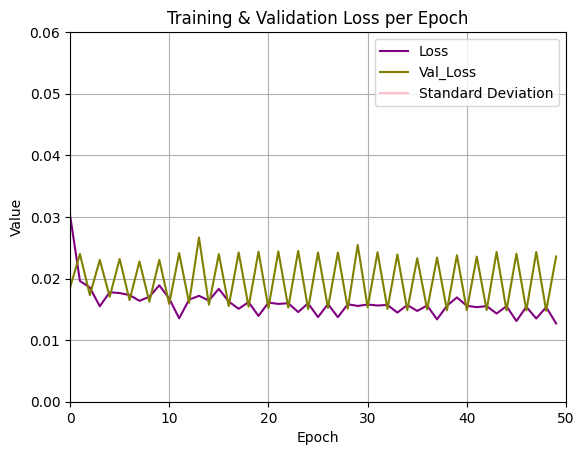

In [42]:
s=[df_Scaled.std()]*len(history6.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history6.history['loss'],  color='purple',label='Loss')
plt.plot(history6.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history6.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model6.png',format='png')
# Muestra el gráfico
plt.show()

In [43]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict6 = model6.predict(test_dataset,steps=len(y_test))

/tmp/ipykernel_6786/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))
W0000 00:00:1729414929.297859 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729414929.322152 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729414929.325995 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729414929.338039 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729414929.343231 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729414929.347071 2027553 gpu_timer.cc:114] Skipping the delay kerne

   23/24725 ━━━━━━━━━━━━━━━━━━━━ 3:00 7ms/step

W0000 00:00:1729414929.766636 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729414929.767151 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729414929.767693 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729414929.768303 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729414929.768819 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729414929.769366 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729414929.769981 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729414929.770644 2027553 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1729414929.771108 2027553 gp

24725/24725 ━━━━━━━━━━━━━━━━━━━━ 189s 8ms/step


In [46]:
mae6 = mean_absolute_error(y_test, predict6)
mse6= mean_squared_error(y_test, predict6)
# Calcular R-squared
r26 = r2_score(y_test, predict6)

smape6 = smape_2(y_test, predict6)

# Imprimir las métricas
print(f"MAE: {mae6}")
print(f"MSE: {mse6}")
print(f"R-squared: {r26}")
print(f"SMAPE: {smape6}%")

MAE: 0.014796338693808093
MSE: 0.000625216108919395
R-squared: 0.5060229065697959
SMAPE: 26.558300357848637%


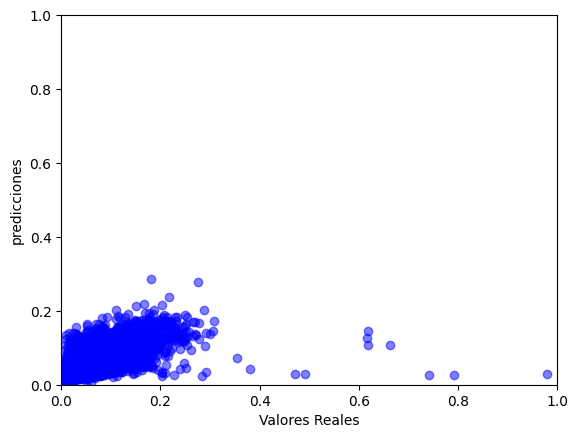

In [47]:
plt.scatter(y_test, predict6, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

/tmp/ipykernel_6786/2528644800.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  residuos.append(float(y_test[a])-float(predict6[a]))


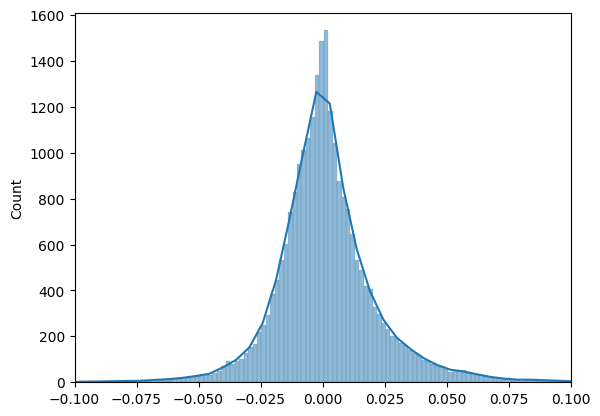

In [48]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict6[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

### Usando 10 días previos para predecir el promedio de la semana siguiente (Capping)

In [49]:
# Definir la longitud de la secuencia para la LSTM
sequence_length = 10  # Supongamos que usas 7 días para la LSTM

# Variables para almacenar las secuencias, el target y las imágenes
X, y, images = [], [], []

# Recorre los datos por locación
for location, location_df in grouped_data.items():
    features = location_df.drop(['Date', 'station', 'mp10', 'image'], axis=1).values
    target = location_df['mp10'].values
    image_series = location_df['image'].values

    for i in range(sequence_length, len(features)):
        # Crear secuencia de entrada de `sequence_length` días
        sequence_features = features[i-sequence_length:i]
        sequence_target = np.mean(target[i:i+7])
        
        # Buscar una imagen en la secuencia (la más cercana al último día de la secuencia)
        image_associated = image_series[i-sequence_length:i]
        image_file = next((img for img in reversed(image_associated) if img != 0), None)
        
        # Añadir solo si hay una imagen válida asociada
        if image_file:
            X.append(sequence_features)
            y.append(sequence_target)
            images.append(image_file)

# Convertir las listas a arrays de numpy
X, y = np.array(X), np.array(y)
images = np.array(images)

# Normalizar características de entrada
scaler_X = MinMaxScaler()
X_reshaped = X.reshape(-1, X.shape[-1])
X_normalized = scaler_X.fit_transform(X_reshaped)
X = X_normalized.reshape(X.shape)

scaler_y = MinMaxScaler()
y = scaler_y.fit_transform(y.reshape(-1, 1))

print(f"Forma de X: {X.shape}, Forma de y: {y.shape}, Total de imágenes: {images.shape}")

# Dividir los datos en 70% entrenamiento, 20% test, 10% validación
X_train, X_temp, y_train, y_temp, images_train, images_temp = train_test_split(X, y, images, test_size=0.30, random_state=42)

# Dividir el 30% restante en 20% test y 10% validación
X_test, X_val, y_test, y_val, images_test, images_val = train_test_split(X_temp, y_temp, images_temp, test_size=0.33, random_state=42)  # 0.33 * 0.30 = ~0.10

# Imprimir las formas para verificar las divisiones
print(f"Train set: X={X_train.shape}, y={y_train.shape}, images={images_train.shape}")
print(f"Test set: X={X_test.shape}, y={y_test.shape}, images={images_test.shape}")
print(f"Validation set: X={X_val.shape}, y={y_val.shape}, images={images_val.shape}")


Forma de X: (123013, 10, 17), Forma de y: (123013, 1), Total de imágenes: (123013,)
Train set: X=(86109, 10, 17), y=(86109, 1), images=(86109,)
Test set: X=(24725, 10, 17), y=(24725, 1), images=(24725,)
Validation set: X=(12179, 10, 17), y=(12179, 1), images=(12179,)


In [50]:
# Definir la entrada para las imágenes (224x224x6)
image_input = Input(shape=(224, 224, 6))

# Red convolucional para procesar la entrada de imágenes
x = Conv2D(filters=16, kernel_size=(3, 3), activation='relu')(image_input)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)
x = Conv2D(filters=32, kernel_size=(3, 3), activation='relu')(x)
x = AveragePooling2D(pool_size=(2, 2))(x)

# Aplanar la salida de la capa convolucional
x = Flatten()(x)
x = Dense(units=128, activation='relu')(x)
x = Dropout(rate=0.5)(x)

# Definir la entrada para la LSTM (datos secuenciales)
sequence_input = Input(shape=(10, 17))  

# Red LSTM para procesar la entrada secuencial
y = LSTM(units=50, return_sequences=True)(sequence_input)
y = LSTM(units=50)(y)

# Combinar las salidas de la CNN y la LSTM
combined = Concatenate()([x, y])

# Añadir capas densas finales para predecir el valor final
z = Dense(units=128, activation='relu')(combined)
z = Dropout(rate=0.5)(z)
z = Dense(units=1, activation='linear')(z)

# Crear el modelo con dos entradas
model7 = Model(inputs=[image_input, sequence_input], outputs=z)

# Compilar el modelo
model7.compile(optimizer='adam', loss='mean_absolute_error',metrics=['mean_squared_error','mean_absolute_percentage_error',smape])

# Mostrar la arquitectura del modelo
model7.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 6)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 222, 222,  │        880 │ input_layer_4[0]… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_8 │ (None, 111, 111,  │          0 │ conv2d_8[0][0]    │
│ (AveragePooling2D)  │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 109, 109,  │      4,640 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_9 │ (None, 54, 54,    │          0 │ conv2d_9[0][0]    │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 52, 52,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 26, 26,    │          0 │ conv2d_10[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 24, 24,    │      9,248 │ average_pooling2… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_pooling2d_… │ (None, 12, 12,    │          0 │ conv2d_11[0][0]   │
│ (AveragePooling2D)  │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4608)      │          0 │ average_pooling2… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, 10, 17)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 128)       │    589,952 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_4 (LSTM)       │ (None, 10, 50)    │     13,600 │ input_layer_5[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_5 (LSTM)       │ (None, 50)        │     20,200 │ lstm_4[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 178)       │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ lstm_5[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 128)       │     22,912 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 128)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │        129 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 670,809 (2.56 MB)

 Trainable params: 670,809 (2.56 MB)

 Non-trainable params: 0 (0.00 B)

In [51]:
# Generador para combinar imágenes y secuencias
def data_generator(image_files, sequences, labels): 
    for i in range(len(image_files)):
        if image_files[i] != '':  # Si la imagen existe
            image = preprocess_imagery(image_files[i])  # Cargar y preprocesar la imagen
            image = tf.convert_to_tensor(image, dtype=tf.float32)
        else:
            image = tf.zeros((224, 224, 6), dtype=tf.float32)  # Si no hay imagen, usar un tensor de ceros
            
        sequence = tf.convert_to_tensor(sequences[i], dtype=tf.float32)  # Secuencia de datos tabulares
        label = tf.convert_to_tensor(labels[i], dtype=tf.float32)  # Etiqueta (mp10)+
        label=tf.squeeze(label)
        
        yield (image, sequence), label  # Dos entradas: imagen y secuencia

# Crear el dataset
def create_combined_dataset(image_files, sequences, labels, batch_size):
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        args=[image_files, sequences, labels],
        output_signature=(
            (tf.TensorSpec(shape=(224, 224, 6), dtype=tf.float32),  # Especificar el tamaño de las imágenes
             tf.TensorSpec(shape=(10, sequences.shape[2]), dtype=tf.float32)),  # Secuencias de 7 días
            tf.TensorSpec(shape=(), dtype=tf.float32)  # La etiqueta (mp10)
        )
    )
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Ejemplo de uso para crear datasets de entrenamiento, validación y prueba
batch_size = 32

# Crear datasets
train_dataset = create_combined_dataset(images_train, X_train, y_train, batch_size)
val_dataset = create_combined_dataset(images_val, X_val, y_val, batch_size)
test_dataset = create_combined_dataset(images_test, X_test, y_test, batch_size)


In [52]:

early_stopping = EarlyStopping(
    monitor='val_loss',  # Métrica a monitorear
    patience=10,         # Número de épocas de paciencia
    restore_best_weights=True  # Restaurar los mejores pesos al final del entrenamiento
)
checkpoint_path = "training_7/ckpt.weights.h5"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [53]:
history7=model7.fit(train_dataset, batch_size=32,epochs=50,steps_per_epoch=len(X_train)//32, validation_data=val_dataset,callbacks=[early_stopping,cp_callback],validation_steps=len(X_val)//32)


Epoch 1/50


/home/benjaxmen/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_38', 'keras_tensor_50']. Received: the structure of inputs=('*', '*')
  warnings.warn(
/tmp/ipykernel_6786/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))


2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step - loss: 0.0707 - mean_absolute_percentage_error: 18814.6250 - mean_squared_error: 0.5701 - smape: 46.2301
Epoch 1: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 537s 197ms/step - loss: 0.0707 - mean_absolute_percentage_error: 18814.1758 - mean_squared_error: 0.5699 - smape: 46.2293 - val_loss: 0.0180 - val_mean_absolute_percentage_error: 12707.2607 - val_mean_squared_error: 7.6100e-04 - val_smape: 46.4472
Epoch 2/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 2:03 46ms/step - loss: 0.0178 - mean_absolute_percentage_error: 22.6828 - mean_squared_error: 6.0718e-04 - smape: 47.3833
Epoch 2: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 63us/step - loss: 0.0178 - mean_absolute_percentage_error: 22.6828 - mean_squared_error: 6.0718e-04 - smape: 23.7005 - val_loss: 0.0172 - val_mean_absolute_percentage_error: 38.2792 - val_mean_squared_error: 9.9115e-04 - val_smape: 24.8435
Epoch 3/50


2024-10-20 10:40:11.418847: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11642950107619294149
2024-10-20 10:40:11.419186: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 10:40:11.419389: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2893754331221869607
2024-10-20 10:40:11.419410: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 10:40:11.419728: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 10:40:11.419744: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 10:40:11.419752: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv

2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - loss: 0.0180 - mean_absolute_percentage_error: 17900.8418 - mean_squared_error: 7.2585e-04 - smape: 43.6829
Epoch 3: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 557s 207ms/step - loss: 0.0180 - mean_absolute_percentage_error: 17900.7051 - mean_squared_error: 7.2585e-04 - smape: 43.6830 - val_loss: 0.0164 - val_mean_absolute_percentage_error: 13317.6396 - val_mean_squared_error: 6.5279e-04 - val_smape: 45.5288
Epoch 4/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:39 104ms/step - loss: 0.0188 - mean_absolute_percentage_error: 22.9893 - mean_squared_error: 8.0469e-04 - smape: 48.5142

2024-10-20 10:49:28.534273: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11642950107619294149
2024-10-20 10:49:28.534693: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 10:49:28.534903: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2893754331221869607
2024-10-20 10:49:28.534920: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 10:49:28.535091: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 10:49:28.535105: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 10:49:28.535113: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 4: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 141us/step - loss: 0.0188 - mean_absolute_percentage_error: 22.9893 - mean_squared_error: 8.0469e-04 - smape: 24.2661 - val_loss: 0.0167 - val_mean_absolute_percentage_error: 36.3562 - val_mean_squared_error: 9.5366e-04 - val_smape: 24.1289
Epoch 5/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step - loss: 0.0177 - mean_absolute_percentage_error: 17873.1875 - mean_squared_error: 0.0024 - smape: 44.1529
Epoch 5: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 570s 212ms/step - loss: 0.0177 - mean_absolute_percentage_error: 17873.0254 - mean_squared_error: 0.0024 - smape: 44.1531 - val_loss: 0.0164 - val_mean_absolute_percentage_error: 13289.9766 - val_mean_squared_error: 6.5078e-04 - val_smape: 43.3741
Epoch 6/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:42 105ms/step - loss: 0.0174 - mean_absolute_percentage_error: 24.4130 - mean_squared_error: 5.9819e-04 - smape: 47.4280

2024-10-20 10:58:59.479670: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11642950107619294149
2024-10-20 10:58:59.480139: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 10:58:59.480369: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2893754331221869607
2024-10-20 10:58:59.480384: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 10:58:59.480592: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 10:58:59.480609: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 10:58:59.480618: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 6: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 119us/step - loss: 0.0174 - mean_absolute_percentage_error: 24.4130 - mean_squared_error: 5.9819e-04 - smape: 23.7228 - val_loss: 0.0155 - val_mean_absolute_percentage_error: 37.9408 - val_mean_squared_error: 7.4010e-04 - val_smape: 23.3922
Epoch 7/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - loss: 0.0169 - mean_absolute_percentage_error: 17472.6289 - mean_squared_error: 6.5373e-04 - smape: 44.5031
Epoch 7: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 578s 215ms/step - loss: 0.0169 - mean_absolute_percentage_error: 17472.4199 - mean_squared_error: 6.5374e-04 - smape: 44.5032 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 13559.7354 - val_mean_squared_error: 6.0049e-04 - val_smape: 45.7350
Epoch 8/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:21 97ms/step - loss: 0.0163 - mean_absolute_percentage_error: 22.6061 - mean_squared_error: 5.0070e-04 - smape: 46.3374

2024-10-20 11:08:37.454433: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11642950107619294149
2024-10-20 11:08:37.454798: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 11:08:37.455016: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2893754331221869607
2024-10-20 11:08:37.455028: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 11:08:37.455215: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 11:08:37.455231: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 11:08:37.455287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 8: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 134us/step - loss: 0.0163 - mean_absolute_percentage_error: 22.6061 - mean_squared_error: 5.0070e-04 - smape: 23.1773 - val_loss: 0.0141 - val_mean_absolute_percentage_error: 30.5128 - val_mean_squared_error: 5.5570e-04 - val_smape: 24.8217
Epoch 9/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - loss: 0.0165 - mean_absolute_percentage_error: 17951.4121 - mean_squared_error: 6.3378e-04 - smape: 44.7497
Epoch 9: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 584s 217ms/step - loss: 0.0165 - mean_absolute_percentage_error: 17951.1992 - mean_squared_error: 6.3379e-04 - smape: 44.7498 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 13655.6768 - val_mean_squared_error: 5.8603e-04 - val_smape: 45.7963
Epoch 10/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:26 99ms/step - loss: 0.0164 - mean_absolute_percentage_error: 21.1008 - mean_squared_error: 5.0509e-04 - smape: 47.9709

2024-10-20 11:18:22.050407: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11642950107619294149
2024-10-20 11:18:22.050773: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 11:18:22.050987: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2893754331221869607
2024-10-20 11:18:22.051004: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 11:18:22.051148: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 11:18:22.051163: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 11:18:22.051170: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 10: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 169us/step - loss: 0.0164 - mean_absolute_percentage_error: 21.1008 - mean_squared_error: 5.0509e-04 - smape: 23.9944 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 30.3402 - val_mean_squared_error: 5.1119e-04 - val_smape: 25.0406
Epoch 11/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0162 - mean_absolute_percentage_error: 17800.9141 - mean_squared_error: 6.1389e-04 - smape: 44.9512
Epoch 11: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 589s 219ms/step - loss: 0.0162 - mean_absolute_percentage_error: 17800.6328 - mean_squared_error: 6.1389e-04 - smape: 44.9513 - val_loss: 0.0152 - val_mean_absolute_percentage_error: 12360.1660 - val_mean_squared_error: 5.7932e-04 - val_smape: 45.4854
Epoch 12/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 8:43 195ms/step - loss: 0.0181 - mean_absolute_percentage_error: 23.6751 - mean_squared_error: 5.7996e-04 - smape: 48.2213

2024-10-20 11:28:11.557275: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11642950107619294149
2024-10-20 11:28:11.557873: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 11:28:11.557888: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2893754331221869607
2024-10-20 11:28:11.557896: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 11:28:11.558240: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 11:28:11.558255: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 11:28:11.558265: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 12: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 187us/step - loss: 0.0181 - mean_absolute_percentage_error: 23.6751 - mean_squared_error: 5.7996e-04 - smape: 24.1196 - val_loss: 0.0147 - val_mean_absolute_percentage_error: 31.4944 - val_mean_squared_error: 5.3128e-04 - val_smape: 24.6260
Epoch 13/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0159 - mean_absolute_percentage_error: 16998.5840 - mean_squared_error: 5.9583e-04 - smape: 45.1118
Epoch 13: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 591s 219ms/step - loss: 0.0159 - mean_absolute_percentage_error: 16998.4043 - mean_squared_error: 5.9583e-04 - smape: 45.1119 - val_loss: 0.0150 - val_mean_absolute_percentage_error: 12991.1846 - val_mean_squared_error: 5.7496e-04 - val_smape: 46.6120
Epoch 14/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 8:28 189ms/step - loss: 0.0163 - mean_absolute_percentage_error: 20.8984 - mean_squared_error: 4.9221e-04 - smape: 51.2887

2024-10-20 11:38:02.996661: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11642950107619294149
2024-10-20 11:38:02.997025: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 11:38:02.997047: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2893754331221869607
2024-10-20 11:38:02.997057: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 11:38:02.997247: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 11:38:02.997263: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 11:38:02.997271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 14: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 206us/step - loss: 0.0163 - mean_absolute_percentage_error: 20.8984 - mean_squared_error: 4.9221e-04 - smape: 25.6539 - val_loss: 0.0156 - val_mean_absolute_percentage_error: 36.4492 - val_mean_squared_error: 5.6401e-04 - val_smape: 24.0039
Epoch 15/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - loss: 0.0158 - mean_absolute_percentage_error: 16954.2070 - mean_squared_error: 5.8791e-04 - smape: 45.2613
Epoch 15: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 598s 221ms/step - loss: 0.0158 - mean_absolute_percentage_error: 16953.9551 - mean_squared_error: 5.8792e-04 - smape: 45.2614 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 13025.6318 - val_mean_squared_error: 5.6441e-04 - val_smape: 45.9148
Epoch 16/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:40 104ms/step - loss: 0.0160 - mean_absolute_percentage_error: 19.7507 - mean_squared_error: 4.6865e-04 - smape: 50.7706

2024-10-20 11:48:01.863146: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[StatefulPartitionedCall/Shape/_10]]
2024-10-20 11:48:01.863717: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11642950107619294149
2024-10-20 11:48:01.863746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 11:48:01.863756: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2893754331221869607
2024-10-20 11:48:01.863765: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 11:48:01.863778: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 11:48:01.863786: 


Epoch 16: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 188us/step - loss: 0.0160 - mean_absolute_percentage_error: 19.7507 - mean_squared_error: 4.6865e-04 - smape: 25.3948 - val_loss: 0.0153 - val_mean_absolute_percentage_error: 38.2190 - val_mean_squared_error: 5.6098e-04 - val_smape: 23.6336
Epoch 17/50
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - loss: 0.0156 - mean_absolute_percentage_error: 16270.8955 - mean_squared_error: 5.7604e-04 - smape: 45.3650
Epoch 17: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 595s 221ms/step - loss: 0.0156 - mean_absolute_percentage_error: 16270.7363 - mean_squared_error: 5.7604e-04 - smape: 45.3651 - val_loss: 0.0148 - val_mean_absolute_percentage_error: 13010.0596 - val_mean_squared_error: 5.6143e-04 - val_smape: 45.7051
Epoch 18/50
   1/2690 ━━━━━━━━━━━━━━━━━━━━ 4:40 104ms/step - loss: 0.0158 - mean_absolute_percentage_error: 20.7756 - mean_squared_error: 5.0023e-04 - smape: 52.1358

2024-10-20 11:57:57.339460: I tensorflow/core/framework/local_rendezvous.cc:427] Local rendezvous send item cancelled. Key hash: 11642950107619294149
2024-10-20 11:57:57.339931: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 5437385474396810061
2024-10-20 11:57:57.339947: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 2893754331221869607
2024-10-20 11:57:57.339956: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 16486678341912116941
2024-10-20 11:57:57.340119: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 10248965053497575848
2024-10-20 11:57:57.340133: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 13959604547610640816
2024-10-20 11:57:57.340140: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv


Epoch 18: saving model to training_7/ckpt.weights.h5
2690/2690 ━━━━━━━━━━━━━━━━━━━━ 1s 193us/step - loss: 0.0158 - mean_absolute_percentage_error: 20.7756 - mean_squared_error: 5.0023e-04 - smape: 26.0776 - val_loss: 0.0146 - val_mean_absolute_percentage_error: 35.3797 - val_mean_squared_error: 5.2313e-04 - val_smape: 24.0780


In [54]:
df_Scaled=df['mp10'].copy()
df_Scaled = df_Scaled  / df_Scaled.abs().max()

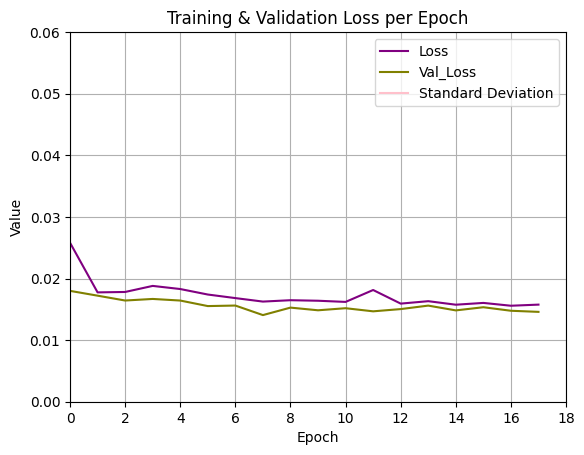

In [56]:
import matplotlib.pyplot as plt
s=[df_Scaled.std()]*len(history7.history['loss'])
colors = ['b', 'g', 'r', 'c', 'm', 'y','k','orange', 'purple', 'brown', 'pink', 'lime', 'teal', 'gray', 'olive', 'navy']

    # Grafica los valores de loss
plt.plot(history7.history['loss'],  color='purple',label='Loss')
plt.plot(history7.history['val_loss'],color='olive',label='Val_Loss')
plt.plot(s,label='Standard Deviation',color='pink')
# Agrega etiquetas al gráfico
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.ylim(0,0.06)
plt.title('Training & Validation Loss per Epoch')
plt.xlim(0,len(history7.history['loss']))

plt.legend()

plt.grid(True)
plt.savefig('val_loss_model7.png',format='png')
# Muestra el gráfico
plt.show()

In [58]:
test_dataset = create_combined_dataset(images_test, X_test, y_test, 1)
predict7 = model7.predict(test_dataset,steps=len(y_test))

/tmp/ipykernel_6786/3120971199.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = (imageio.imread(path))
/home/benjaxmen/tf/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_38', 'keras_tensor_50']. Received: the structure of inputs=('*', '*')
  warnings.warn(


24725/24725 ━━━━━━━━━━━━━━━━━━━━ 187s 8ms/step


In [59]:
# Calcular MAE
mae7 = mean_absolute_error(y_test, predict7)
mse7= mean_squared_error(y_test, predict7)
# Calcular R-squared
r27 = r2_score(y_test, predict7)
smape7 = smape_2(y_test, predict7)

# Imprimir las métricas
print(f"MAE: {mae7}")
print(f"MSE: {mse7}")
print(f"R-squared: {r27}")
print(f"SMAPE: {smape7}%")

MAE: 0.015592373370709902
MSE: 0.0006481501150274539
R-squared: 0.5455060274503385
SMAPE: 21.80329768284648%


In [ ]:
plt.scatter(y_test, predict7, color='blue', alpha=0.5)

plt.xlabel('Valores Reales')
plt.ylabel('predicciones')
plt.xlim(0,1)
plt.ylim(0,1)

plt.show()

In [ ]:
residuos = []
for a in range(len(y_test)):
    residuos.append(float(y_test[a])-float(predict7[a]))
sns.histplot(residuos,kde=True,bins=600)
plt.xlim(-0.1,0.1)
plt.show()

In [61]:
mae0=0.024951122207249193
mse0=0.00127273699185358
r20=0.15893306975515364
smape0=36.60100083635075
mae1=0.015039202210330043
mse1=0.0006509588000405462
r21=0.569824776705353
smape1=20.962979259932805
mae2=0.014961800408023352
mse2=0.0006376001851182003
r22=0.49623836986603576
smape2=26.88063364076384
mae3=0.015111808376505815
mse3=0.0006279599663901092
r23=0.5596637058149658
smape3=21.026700528941657
mae4=0.018601448325700865
mse4=0.0009028183161912945
r24=0.2993115697945907
smape4=33.3972011408633
mae5=0.014784230964475288
mse5=0.000636672932877727
r25=0.5792653528160695
smape5=19.800282392672976


In [63]:
mae_list = [mae0, mae1, mae2, mae3, mae4, mae5, mae6, mae7]
mse_list = [mse0, mse1, mse2, mse3, mse4, mse5, mse6, mse7]
r2_list = [r20, r21, r22, r23, r24, r25, r26, r27]
smape_list = [smape0, smape1, smape2, smape3, smape4, smape5, smape6, smape7]

# Crear una lista de modelos del 0 al 7
modelos = list(range(8))

# Crear un diccionario con los datos
data = {
    'Modelo': modelos,
    'MAE': mae_list,
    'MSE': mse_list,
    'R2': r2_list,
    'SMAPE': smape_list
}

# Crear un DataFrame de pandas con los datos
dfs = pd.DataFrame(data)

# Mostrar el DataFrame
print(dfs)


   Modelo       MAE       MSE        R2      SMAPE
0       0  0.024951  0.001273  0.158933  36.601001
1       1  0.015039  0.000651  0.569825  20.962979
2       2  0.014962  0.000638  0.496238  26.880634
3       3  0.015112  0.000628  0.559664  21.026701
4       4  0.018601  0.000903  0.299312  33.397201
5       5  0.014784  0.000637  0.579265  19.800282
6       6  0.014796  0.000625  0.506023  26.558300
7       7  0.015592  0.000648  0.545506  21.803298


In [ ]:
dfs.to_csv('trial1.csv',index=False)